# Check if the tidal elevation error has reached the equilibrium

In [1]:
%matplotlib inline
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_JSL    = '/g/data/nm03/lxy581/archive/tides_025_SAL_JSL/output011/ocean_interior.nc'
file_stats  = '/g/data/nm03/lxy581/archive/tides_025_SAL_JSL/output011/ocean_static.nc'

In [3]:
JSL    = xr.open_dataset(file_JSL)
stat   = xr.open_dataset(file_stats)

In [4]:
depth  = stat['deptho']
geolat = stat['geolat']
geolon = stat['geolon']
yh, xh = stat.yh, stat.xh
fac_dep = xr.where(depth > 1000, 1, np.nan) 
fac_lat = xr.where((geolat < 75) & (geolat > -75), 1, np.nan)

In [5]:
print(fac_dep.shape)

(1080, 1440)


In [6]:
ny, nx = JSL.yh.size, JSL.xh.size
elev_err_JSL_x6 = np.full((24,),np.nan)
elev_JSL_3D  = np.full((149,ny,nx),np.nan)

In [7]:
tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')
pha_tpxo = tpxo.hp.isel({'nc':0}).transpose() /180 *np.pi
amp_tpxo = tpxo.ha.isel({'nc':0}).transpose()
lon_tpxo = tpgd.lon_z.transpose()
lat_tpxo = tpgd.lat_z.transpose()
hz_tpxo  = tpgd.hz.transpose()
ny, nx   = tpgd.ny, tpgd.nx

In [8]:
ds_tpxo_data = xr.Dataset(data_vars={'pha_tpxo': (('ny','nx'), np.array(pha_tpxo)),
                                     'amp_tpxo': (('ny','nx'), np.array(amp_tpxo)),
                                     'hz_tpxo': (('ny','nx'), np.array(hz_tpxo))},
                          coords={'lon': (('ny', 'nx'), np.array(lon_tpxo)), 
                                  'lat': (('ny', 'nx'), np.array(lat_tpxo))})
ds_mom6_grid = xr.Dataset({"lat": (["yh","xh"], np.array(geolat)),
                           "lon": (["yh","xh"], np.array(geolon))})
regridder = xe.Regridder(ds_tpxo_data, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
ds_tpxo_mom6_grid = regridder(ds_tpxo_data)

In [9]:
days = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31])
days_accum = np.cumsum(days)
print(days_accum)

[  0  31  59  90 120 151 181 212 243 273 304 334 365]


In [11]:
def get_elev_monthly(exp_name):
    elev_err_JSL = np.full((12,),np.nan)
    for i in range(12):
        print('Month %02d'%i)
        file = '/scratch/nm03/lxy581/mom6/archive/%s/output0%02d/ocean_interior.nc'%(exp_name,i)
        print(file)
        data = xr.open_dataset(file)
        elev_JSL_3D = np.array(data.e.isel({'time':np.arange(149),'zi':0}))
        t_12cyc = np.arange(149)
        nt_tpxo = t_12cyc.size
        omega_m2 = np.full((nt_tpxo,yh.size,xh.size),(2*np.pi/(12+5/12)))
        elev_tpxo = np.array(ds_tpxo_mom6_grid['amp_tpxo'])[None,:,:] * np.cos(omega_m2 * (t_12cyc[:,None,None]+days_accum[i]*24) - np.array(ds_tpxo_mom6_grid['pha_tpxo'])[None,:,:])
        elev_err_JSL[i] = np.nanmean(np.sqrt(np.nanmean((elev_JSL_3D * np.array(fac_lat)[None,:,:] * np.array(fac_dep)[None,:,:] - elev_tpxo * np.array(fac_lat)[None,:,:] * np.array(fac_dep)[None,:,:])**2,axis=0))) *100
        print(elev_err_JSL[i])
        print('End the loop \n')
    return elev_err_JSL

In [12]:
elev_err_JSL_x6 = get_elev_monthly('tides_025_SAL_JSL_x10')

Month 00
/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output000/ocean_interior.nc
15.23471596781433
End the loop 

Month 01
/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output001/ocean_interior.nc
10.993448844325275
End the loop 

Month 02
/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output002/ocean_interior.nc
9.916031486423805
End the loop 

Month 03
/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output003/ocean_interior.nc
8.963128872069626
End the loop 

Month 04
/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output004/ocean_interior.nc
8.39677142823199
End the loop 

Month 05
/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output005/ocean_interior.nc
8.315097973216808
End the loop 

Month 06
/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output006/ocean_interior.nc
8.8075565872942
End the loop 

Month 07
/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output007/ocean_interior.nc
9.875444627649577
End the l

In [13]:
print(elev_err_JSL_x6)

[15.23471597 10.99344884  9.91603149  8.96312887  8.39677143  8.31509797
  8.80755659  9.87544463 11.29173097 12.83406952 14.52240757 16.20596634]


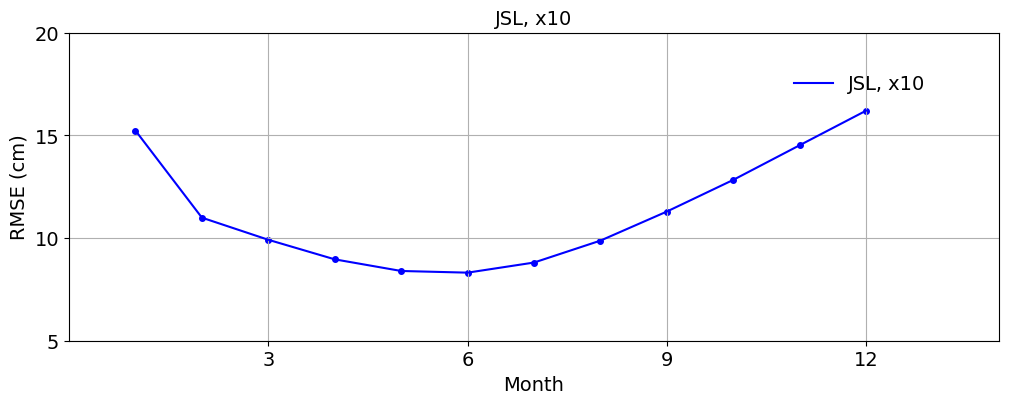

In [14]:
fig = plt.figure(figsize=(12, 4))
# plt.plot(np.arange(12),elev_err_JSL,'k-',label='not tuned')
plt.plot(np.arange(12),elev_err_JSL_x6,'b-',label='JSL, x10')
# plt.scatter(np.arange(12),elev_err_JSL,marker='o',color='k',s=16)
plt.scatter(np.arange(12),elev_err_JSL_x6,marker='o',color='b',s=16)
plt.legend(bbox_to_anchor=(0.94,0.92),fontsize=14,frameon=False)
plt.ylim(5,20)
plt.xlim(-1,13)
plt.xlabel('Month',fontsize=14)
plt.xticks(np.arange(2,12,3),labels=['3','6','9','12'])
plt.yticks(np.arange(5,25,5),labels=['5','10','15','20'])
plt.ylabel('RMSE (cm)',fontsize=14)
plt.title('JSL, x10',fontsize=14)
plt.grid(True)
plt.tick_params(labelsize=14)
plt.savefig('/g/data/nm03/lxy581/evaluate/tuning/SAL_JSL_x10_TPXO_M2_RMSE_time_series.png', dpi=100, bbox_inches='tight')